In [7]:
!nvidia-smi

Mon Mar 24 14:27:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:01:00.0 Off |                    0 |
| N/A   39C    P0             87W /  500W |       5MiB /  81920MiB |      0%   E. Process |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import torch
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import numpy as np
from maestro.trainer.models.florence_2.core import train
from maestro.trainer.models.florence_2.inference import predict
from maestro.trainer.models.florence_2.checkpoints import OptimizationStrategy, load_model
import supervision as sv
from supervision.geometry.core import Position
# if torch.cuda.is_available():
#     DEVICE = torch.device("cuda:3")
# else:
#     DEVICE = torch.device("cpu")
#     print("CUDA is not available, using CPU")

In [25]:
dataset_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/swinir_data/lucknow_airshed_most_15/images"
annotations_path = "/home/nupoor.assudani/cs299_main/florence2_finetuning/separate_train/_annotations.coco.json"

In [1]:
id = 34

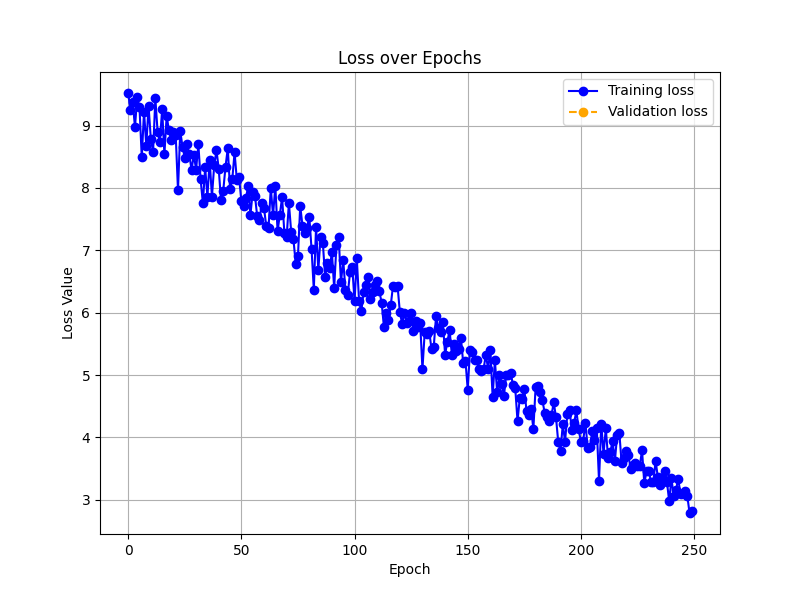

In [3]:
from IPython.display import Image

Image(filename=f"./training/florence_2/{id}/metrics/loss_plot.png", height=600)

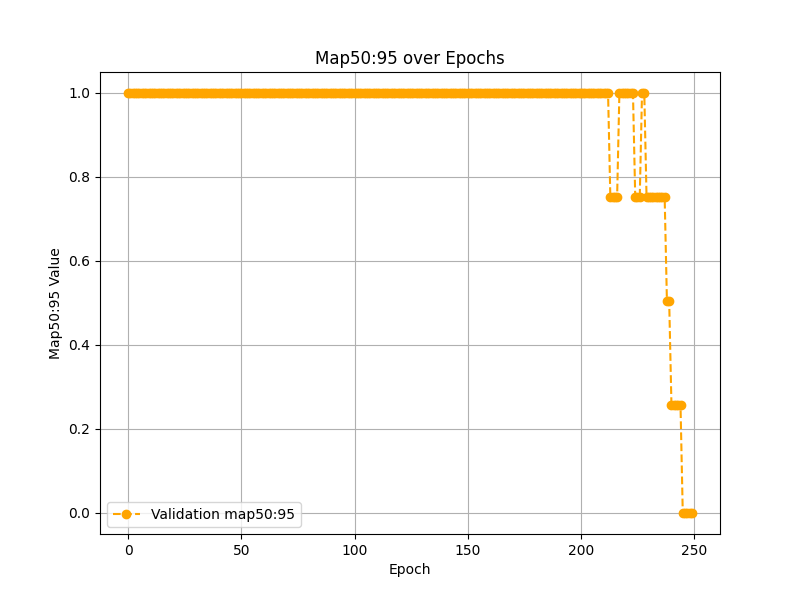

In [4]:
from IPython.display import Image

Image(filename=f"./training/florence_2/{id}/metrics/map50:95_plot.png", height=600)

In [5]:
from maestro.trainer.models.florence_2.checkpoints import OptimizationStrategy, load_model

processor, model = load_model(
    model_id_or_path=f"./training/florence_2/{id}/checkpoints/latest",
    revision = "refs/heads/main",
    # optimization_strategy=OptimizationStrategy.NONE,
)

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [26]:
from maestro.trainer.common.datasets.coco import COCODataset

test_dataset = COCODataset(
    annotations_path=annotations_path,
    images_directory_path=dataset_path,
)

CLASSES = test_dataset.classes
CLASSES

[INFO] maestro - Loaded 90 valid entries out of 90 from '/home/nupoor.assudani/cs299_main/florence2_finetuning/separate_train/_annotations.coco.json'. Skipped 0. Found 0 entries with empty detections.


['brick kilns with chimney', 'background']

In [10]:
from maestro.trainer.models.florence_2.loaders import evaluation_collate_fn, train_collate_fn
from maestro.trainer.models.florence_2.detection import (
    detections_to_prefix_formatter,
    detections_to_suffix_formatter,
)

from functools import partial

from maestro.trainer.common.datasets.core import create_data_loaders

train_loader, valid_loader, test_loader = create_data_loaders(
                    dataset_location= './dynamic_lucknow_coco_train_test',
                    train_batch_size= 32,
                    train_collect_fn= partial(train_collate_fn, processor=processor),
                    # train_num_workers=10,
                    test_batch_size= 4,
                    test_collect_fn= partial(evaluation_collate_fn, processor=processor),
                    detections_to_prefix_formatter=detections_to_prefix_formatter,
                    detections_to_suffix_formatter=detections_to_suffix_formatter,
                    )

[INFO] maestro - Creating data loaders from './dynamic_lucknow_coco_train_test'...
[INFO] maestro - Detected COCO dataset format.
[INFO] maestro - Found COCO split 'train' at: ./dynamic_lucknow_coco_train_test/train/_annotations.coco.json
[INFO] maestro - Loaded 32 valid entries out of 32 from './dynamic_lucknow_coco_train_test/train/_annotations.coco.json'. Skipped 0. Found 0 entries with empty detections.
[INFO] maestro - Found COCO split 'valid' at: ./dynamic_lucknow_coco_train_test/valid/_annotations.coco.json
[INFO] maestro - Loaded 649 valid entries out of 649 from './dynamic_lucknow_coco_train_test/valid/_annotations.coco.json'. Skipped 0. Found 0 entries with empty detections.
[INFO] maestro - Found COCO split 'test' at: ./dynamic_lucknow_coco_train_test/test/_annotations.coco.json
[INFO] maestro - Loaded 649 valid entries out of 649 from './dynamic_lucknow_coco_train_test/test/_annotations.coco.json'. Skipped 0. Found 0 entries with empty detections.
[INFO] maestro - Initializ

In [11]:
def add_class_ids_and_confidence(detection):

    detection.class_id = []
    detection.confidence = []
    # print(detection.data) ####
    if detection.data!={}:
        for class_name in detection.data['class_name']:
            try:
                detection.class_id.append(CLASSES.index(class_name))
            except:
                detection.class_id.append(len(CLASSES)) # if class name is different from ['brick kilns with chimney', 'background'] assign class id other than 0 & 1
            detection.confidence.append(1) # florence_2 does not give confidence score so no use of conf_threshold
        
    return detection

In [13]:
model.device

device(type='cuda', index=0)

In [14]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")
    print("CUDA is not available, using CPU")

In [15]:
import supervision as sv
from tqdm import tqdm

from maestro.trainer.models.florence_2.inference import predict_with_inputs

predictions = []
targets = []

for input_ids, pixel_values, images, prefixes, suffixes in tqdm(test_loader):
    generated_texts = predict_with_inputs(model=model, processor=processor, input_ids=input_ids, pixel_values=pixel_values, device = DEVICE)

    for generated_text in generated_texts:
        predicted_result = processor.post_process_generation(text=generated_text, task="<OD>", image_size=(images[0].width, images[0].height))
        predicted_result = sv.Detections.from_lmm(lmm='florence_2',
                result=predicted_result,
                resolution_wh=(320, 320))
        predicted_result = add_class_ids_and_confidence(predicted_result)
        predictions.append(predicted_result)

    for suffix in suffixes:
        target_result = processor.post_process_generation(text=suffix, task="<OD>", image_size=(images[0].width, images[0].height))
        target_result = sv.Detections.from_lmm(lmm='florence_2',
                result=target_result,
                resolution_wh=(320, 320))
        target_result = add_class_ids_and_confidence(target_result)
        targets.append(target_result)
    

  0%|          | 0/163 [00:00<?, ?it/s]from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
LMM is deprecated: `LMM` enum is deprecated and will be removed in `supervision-0.31.0`. Use VLM instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
LMM is deprecated: `LMM` enum is deprecated and will be

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances
0,0.1,0.081013,0.251969,0.122605,32.0,363.0,95.0,127.0
0,0.3,0.075949,0.236220,0.114943,30.0,365.0,97.0,127.0
0,0.5,0.063291,0.196850,0.095785,25.0,370.0,102.0,127.0
0,0.7,0.035443,0.110236,0.053640,14.0,381.0,113.0,127.0




Plot of Confusion matrix at IoU 0.7


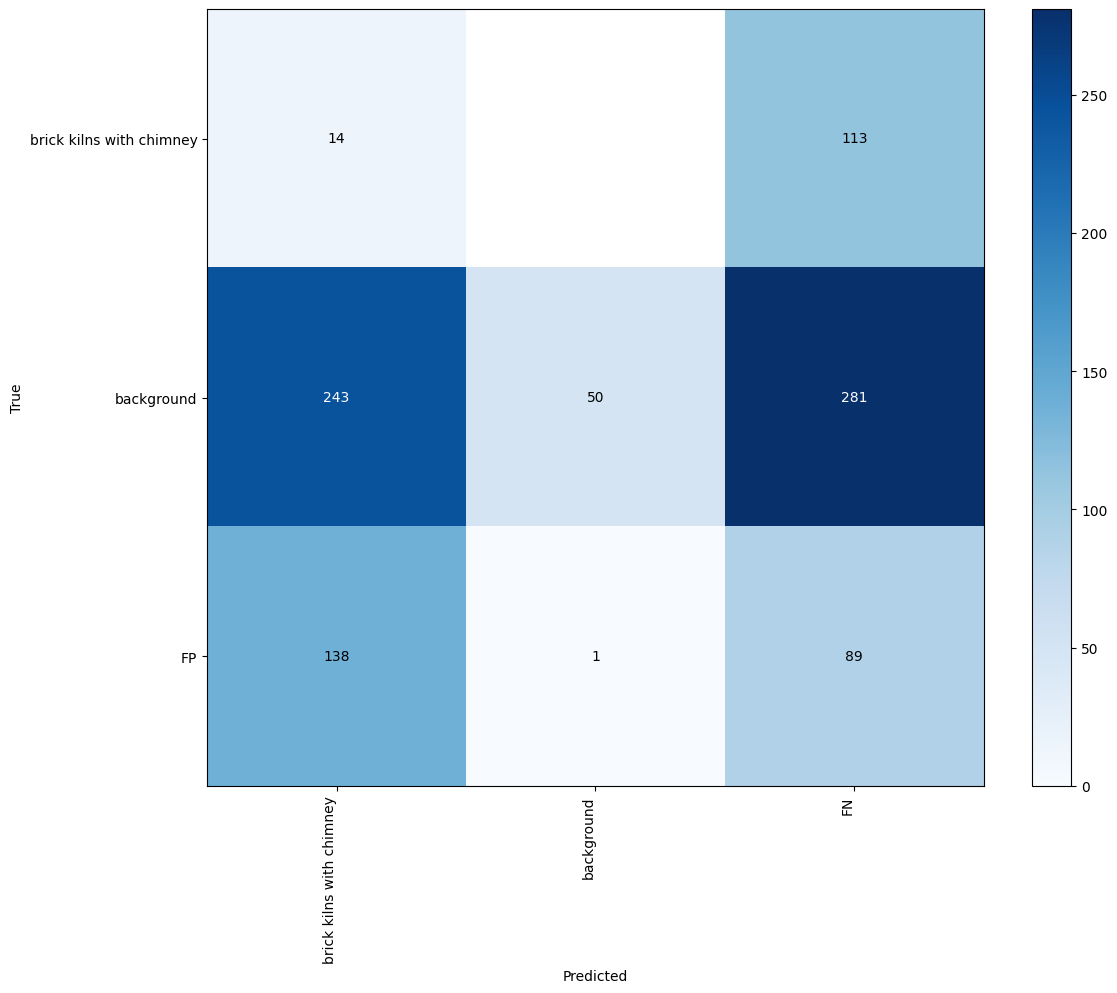

In [16]:
import pandas as pd

df = pd.DataFrame({}, columns = ['IoU', 'Precision', 'Recall', 'F1 score', 'TP', 'FP', 'FN', 'Kiln instances'])
for iou in [0.1,0.3,0.5,0.7]:
    confusion_matrix = sv.ConfusionMatrix.from_detections(
        predictions=predictions,
        targets=targets,
        classes=CLASSES,
        conf_threshold = 0.25, # florence_2 does not give confidence score so no use of conf_threshold  
        iou_threshold=iou
    )

    # calculate precision recall and f1-score
    cm = confusion_matrix.matrix
    tp = cm[0][0]
    predicted_positives = cm[:,0].sum()
    actual_positives = cm[0, :].sum()
    precision = tp/ (predicted_positives + 1e-9)
    recall = tp/ (actual_positives + 1e-9)
    f1_score = 2*precision*recall / (precision + recall)
    false_positives = predicted_positives - tp

    df = pd.concat([df, pd.DataFrame({'IoU': iou, 'Precision': precision, 'Recall': recall, 'F1 score': f1_score, 'TP': tp, 'FP': false_positives, 'FN': actual_positives - tp, 'Kiln instances': actual_positives}, index = [0])])
display(df)

print(f'\n\nPlot of Confusion matrix at IoU {iou}')
_ = confusion_matrix.plot()

In [20]:
visualize_path = "/home/nupoor.assudani/cs299_main/florence2_finetuning/dynamic_lucknow_coco_train_test/train"
vis_anno_path = "/home/nupoor.assudani/cs299_main/florence2_finetuning/dynamic_lucknow_coco_train_test/train/_annotations.coco.json"
num_to_see = 32

from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use 

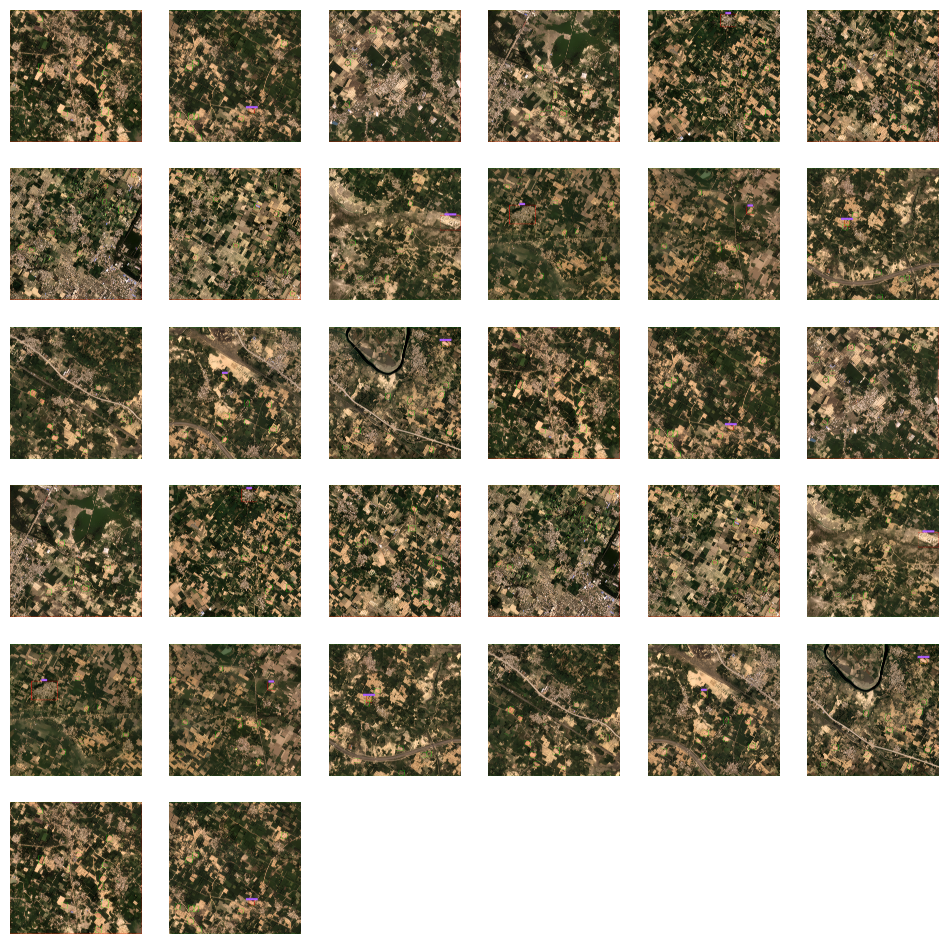

: 

In [ ]:
from supervision.geometry.core import Position

from maestro.trainer.models.florence_2.inference import predict

annotated_images = []

# test_dataset = COCODataset(
#     annotations_path=vis_anno_path,
#     images_directory_path=visualize_path,
# )

for i in range(num_to_see):
    image, annotation = test_dataset[i]

    generated_text = predict(model=model, processor=processor, image=image, prefix="<OD>")
    result = processor.post_process_generation(text=generated_text, task="<OD>", image_size=(image.width, image.height))
    detections = sv.Detections.from_lmm(lmm=sv.LMM.FLORENCE_2, result=result, resolution_wh=image.size)

    annotated_image = image.copy()
    annotated_image = sv.BoxAnnotator(thickness = 4, color=sv.Color(r=255, g=0, b=0), color_lookup=sv.ColorLookup.INDEX).annotate(
        scene=annotated_image, detections=detections
    )
    annotated_image = sv.BoxAnnotator(thickness = 2, color=sv.Color(r=0, g=255, b=0), color_lookup=sv.ColorLookup.INDEX).annotate(
        scene=annotated_image, detections=annotation
    )
    annotated_image = sv.LabelAnnotator(text_scale=1, text_thickness=1, text_position= Position.TOP_CENTER ,smart_position=True, color_lookup=sv.ColorLookup.INDEX).annotate(
        scene=annotated_image, detections=detections
    )
    
    annotated_images.append(annotated_image)

sv.plot_images_grid(annotated_images, (6,6))